# FISHFactor Demo

In [14]:
import torch
from src import fishfactor, simulation, utils
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = 'cpu' # or 'cuda:x'
masks = torch.load('../data/3t3/masks.pkl')

In [5]:
data = simulation.simulate_data(
    n_genes=50,
    n_factors=2,
    masks=masks[:3],
    intensity_scales=torch.full([3, 50], 300),
    factor_lengthscales=torch.tensor([0.5, 0.5]).repeat(3, 1),
    weight_sparsity=0.7,
    factor_sparsity=1.,
    )

In [33]:
data['coordinates'].head(10)

,x,y,gene,cell,gene_id,cell_id
0,0.741227,0.354628,0.0,0.0,0,0
1,0.790643,0.336523,0.0,0.0,0,0
2,0.414611,0.100201,0.0,0.0,0,0
3,0.730660,0.165634,0.0,0.0,0,0
4,0.480476,0.180373,0.0,0.0,0,0
5,0.426904,0.036443,0.0,0.0,0,0
6,0.658691,0.313842,0.0,0.0,0,0
7,0.298183,0.286549,0.0,0.0,0,0
8,0.526974,0.443591,0.0,0.0,0,0
9,0.206737,0.225774,0.0,0.0,0,0


In [6]:
model = fishfactor.FISHFactor(
    data=data['coordinates'],
    n_factors=2,
    device=device,
    n_inducing=50,
    grid_res=50,
    factor_smoothness=0.5,
    masks_threshold=0.5,
    init_bin_res=5
).to(device=device)

In [7]:
model.inference(save=False)

epoch: 0, cell: 0, improvement: 0.0093, patience: 100
epoch: 0, cell: 1, improvement: 0.0023, patience: 100
epoch: 0, cell: 2, improvement: -0.0118, patience: 100
epoch: 1, cell: 0, improvement: 0.0198, patience: 99
epoch: 1, cell: 1, improvement: 0.0129, patience: 99
epoch: 1, cell: 2, improvement: 0.0176, patience: 99
epoch: 2, cell: 0, improvement: 0.026, patience: 98
epoch: 2, cell: 1, improvement: 0.0134, patience: 98
epoch: 2, cell: 2, improvement: 0.0281, patience: 98
epoch: 3, cell: 0, improvement: 0.0289, patience: 97
epoch: 3, cell: 1, improvement: 0.0144, patience: 97
epoch: 3, cell: 2, improvement: 0.0788, patience: 97
epoch: 4, cell: 0, improvement: 0.0394, patience: 96
epoch: 4, cell: 1, improvement: 0.0233, patience: 96
epoch: 4, cell: 2, improvement: 0.0996, patience: 96
epoch: 5, cell: 0, improvement: 0.0406, patience: 95
epoch: 5, cell: 1, improvement: 0.0236, patience: 95
epoch: 5, cell: 2, improvement: 0.0837, patience: 95
epoch: 6, cell: 0, improvement: 0.0474, pat

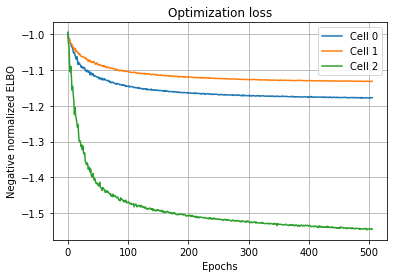

In [25]:
fig, ax = plt.subplots()

for cell in range(model.n_cells):
    ax.plot(np.arange(len(model.losses[cell])), model.losses[cell], label='Cell {}'.format(cell))

ax.legend()
ax.set_title('Optimization loss')
ax.set_ylabel('Negative normalized ELBO')
ax.set_xlabel('Epochs')
ax.grid()
plt.show()

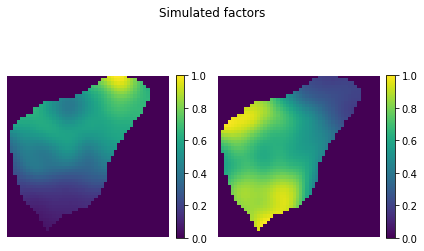

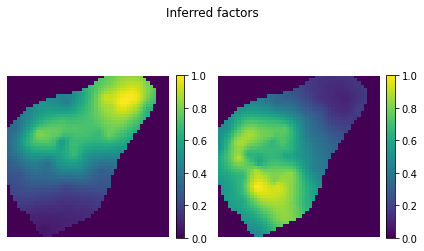

In [58]:
z = model.get_factors()
z = torch.nan_to_num(z, 0)
z_data = data['z']

inds, _ = utils.optimal_assignment(z_data, z, 1)
z = z[:, inds]
z /= z.flatten(start_dim=2).max(dim=-1)[0].view(model.n_cells, model.n_factors, 1, 1)

cell = 1

fig, axs = plt.subplots(1, z.shape[1])
for factor in range(z.shape[1]):
    im = axs[factor].matshow(z_data[cell, factor], origin='lower')
    axs[factor].axis('off')
    plt.colorbar(im, ax=axs[factor], fraction=0.046, pad=0.04)
plt.suptitle('Simulated factors')
plt.tight_layout()

fig, axs = plt.subplots(1, z.shape[1])
for factor in range(z.shape[1]):
    im = axs[factor].matshow(z[cell, factor], origin='lower')
    axs[factor].axis('off')
    plt.colorbar(im, ax=axs[factor], fraction=0.046, pad=0.04)
plt.suptitle('Inferred factors')
plt.tight_layout()

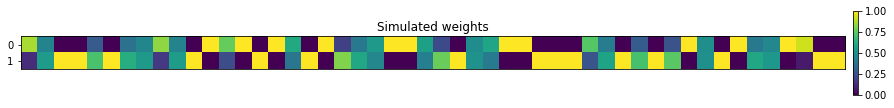

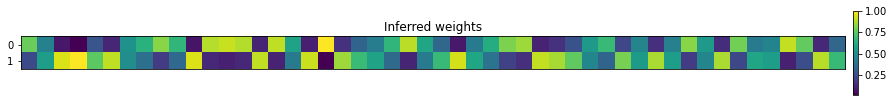

In [68]:
w = model.get_weights()
w = w[:, inds]
w /= w.max(dim=0)[0].unsqueeze(0)
w_data = data['w'][0]

fig, ax = plt.subplots(figsize=(15, 3))
im = ax.matshow(w_data.T, cmap='viridis')
ax.set_title('Simulated weights')
ax.set_xticks([])
plt.colorbar(im, ax=ax, fraction=0.005, pad=0.01)
plt.show()

fig, ax = plt.subplots(figsize=(15, 3))
im = ax.matshow(w.T, cmap='viridis')
ax.set_title('Inferred weights')
ax.set_xticks([])
plt.colorbar(im, ax=ax, fraction=0.005, pad=0.01)
plt.show()